# <p style='color:green; background-color:yellow; text-align:center'>RAPORT TP NUMÉRO 2 : INDEXATION D’IMAGES <br></p>


## Introduction

L'informatique est devenue de plus en plus importante, dispersée et variée sur tout le monde ce qui impose un problème de recherche et d'exploration des données d'où l'objectif des moteurs de recherche qui est de mettre à la disposition du public une constellation de sites et moyens divers traitant aussi bien de l'actualité que des sciences et des technologies ou encore de l'art et de la culture. Dans ces moteurs de recherche ou annuaires, se côtoient des sites de tout horizon.

L'offre étant pléthorique et la concurrence de plus en plus forte, il devient considérablement difficile d'obtenir le référencement dans les outils de recherche. Pour parvenir à se référencer auprès de ces derniers, une bonne connaissance de leur fonctionnement et de leurs méthodes d'indexation est indispensable.

Ce projet rapport a pour but l'implémentation et la conception d'un moteur de recherche d'images qui représente de nos jours une solution favorable pour atteindre l'information dispersée sur le web plus particulièrement et ou dans une base d'image.

Les différentes étapes de notre travail seront les suivantes :

    1- La premières partie s'occuperras de notre fonction d'indexation

    2- La deuxième parie, sera consacré a la fonction de recherche. 

    3- La troisième partie contiendra la fonction d'analyse complete de nos résultats obtenue.
    
    4- une conclusion sur l'ensemble d'étude menée

### 1- PARTIE 1: fonction d'indexation

In [6]:
import cv2
import numpy as np
import os
import glob
import pickle 
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from comon import extraction_features, features

In [7]:
#creation de l'objet d'extraction de SIFT()
extractor = cv2.xfeatures2d.SIFT_create(200)

#definition de la fonction de representation de l'histogramme de tous les image de la base de travail
def build_histogram(descriptor_list, cluster_alg, normal_number):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        #normalisation de l'histogramme en utilisant le rapport par rapport au nombre de mots visuels par image
        histogram[i] += 1/#
    return histogram

#construction histogramme générale
preprocessed_image = []
descriptors,keypoints=extraction_features('image',200)

#sauvegarde des descripteurs extrait
pickle.dump(descriptors,open('serial/new_descriptors','wb'))

#recherche des centroides de l'images en utilisant les kmeans
kmeans = KMeans(n_clusters = 150)
kmeans.fit(descriptors)

#sauvegarde des centroides
pickle.dump(kmeans,open('serial/new_kmean','wb'))

#extraction des histogrammes de tous mes images 
for image in files_img:
      image = cv2.imread(image)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      keypoint, descriptor = features(image, extractor)
      if (descriptor is not None):
          histogram = build_histogram(descriptor, kmeans, 150)
          preprocessed_image.append(histogram)
        
        
#sauvegarde des histogramme          
pickle.dump(preprocessed_image,open('serial/new_histo','wb'))


### SIFT()

### KMeans()

#### AU FINAL NOUS OBTENONS LE SAC DE MOTS que nous avons stoker dans la variable contenant l'nesemble des histogramme de toutes les images (preprocessed_image)

## 2- PARTIE 2: Fonction de recherche.

#### Principe

In [18]:
import cv2
import numpy as np
import os
import pickle 
from sklearn.neighbors import NearestNeighbors
from comon import features, build_histogram
from comon import extraction_features, features



In [26]:
from comon import features, build_histogram
import cv2

                
path_imgg = ('image/999.jpg')
nb_near_img_search = 10
#distance = (sys.argv[3])

extractor = cv2.xfeatures2d.SIFT_create(200)


def recherche(path_imgg,nb_near_img_search):
    #image de test
    data_path_test = os.path.normpath(path_imgg)
    #lecture de l'image
    img_test = cv2.imread(data_path_test)
    #passage de l'image en niveau de gris
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
    #utilisation des descripteur SIFT
    keypoint, descriptor = features(img_test, extractor)
    
    #rechargement du kmean
    kmeans = pickle.load(open('serial/new_kmean','rb'))
    
    #représentation de l'histogramme de l'image de recherche
    histogram = build_histogram(descriptor, kmeans,150)
    
    #recherche des k plus proche voisin de notre image par comparaison des distance au histogramme
    neighbor = NearestNeighbors(n_neighbors = int(nb_near_img_search))
   
    #recharge des histogramme de tous les images
    preprocessed_image = pickle.load(open('serial/new_histo','rb'))
    
    #entrainement pour le knn pour ensuite faire la prediction
    neighbor.fit(preprocessed_image)
    
    #affichage des 10 voisins de notre image recherche
    X_train = [histogram]
    dist, result = neighbor.kneighbors(X_train)
    
    result = np.reshape(result,(-1,1))
    return result


resultat = recherche(path_imgg,nb_near_img_search)

print(resultat)

[[923]
 [ 67]
 [698]
 [179]
 [635]
 [932]
 [958]
 [902]
 [651]
 [693]]


### 3- PARTIE 3: FONCTION D'ANALYSE COMPLETE DES RÉSULTATS OBTENUES

In [57]:
import cv2
import numpy as np
import os
import pickle 
from sklearn.neighbors import NearestNeighbors
from comon import features, build_histogram,dico_voisin_each_image,analyse_result,precision_moyenne
import glob

In [58]:
#construction histogramme générale
preprocessed_image = []

data_path = os.path.join('image','*g')
files_img = glob.glob(data_path)

extractor = cv2.xfeatures2d.SIFT_create(200)

#chargement de nos centroide
kmeans = pickle.load(open('serial/new_kmean','rb'))
#chargement des histogramme de toutes les images
preprocessed_image = pickle.load(open('serial/new_histo','rb'))

#dictionnaire contenant tous les 10 voisins pour chaque images.
#la fonction dico_voisin_each_image() est une fonction qui prend en paramètre l'ensemble des images et pour chaque 
# image il renvoie ses 10 voisins plus proches en utilisant la distance de "minkoswki"
dic_neigbor = dico_voisin_each_image(files_img,preprocessed_image,kmeans)   

#serialisation des résultats obtenue
pickle.dump(dic_neigbor,open('serial/new_dic_neigbor','wb'))

#récupération de tous les faux positif pour chaque image et pour chaque concept
dic_precision_concept, dico_moyenne,dic_faux_positif=analyse_result(dic_neigbor)

#calcul des précision moyenne pour chaque concept en fonction du résultat totale des recheche
afr,pla,monu,bus,dino,ele,fle,che,mont,nourr=precision_moyenne(dico_moyenne)  


dico_precision_moyenne_generale={}   

#enregistrement des precision moyenne par concep
dico_precision_moyenne_generale['Afrique']=afr
dico_precision_moyenne_generale['plage']=pla
dico_precision_moyenne_generale['monument']=monu
dico_precision_moyenne_generale['bus']=bus
dico_precision_moyenne_generale['dinosaure']=dino
dico_precision_moyenne_generale['éléphant']=ele
dico_precision_moyenne_generale['fleur']=fle
dico_precision_moyenne_generale['cheval']=che
dico_precision_moyenne_generale['montagne']=mont
dico_precision_moyenne_generale['nourriture']=nourr

print('fonction d\'evaluation terminé')

fonction d'evaluation terminé


### -----------------------------------------------------------------ANALYSE------------------------------------------------------------------------------

##### a-) affichage et exploitation dic_neigbor()

In [59]:
#dic_neigbor = dico_voisin_each_image(files_img,preprocessed_image,kmeans)  

print(dic_neigbor)

{161: array([[  0],
       [622],
       [502],
       [651],
       [437],
       [285],
       [355],
       [674],
       [993],
       [664]]), 952: array([[  1],
       [630],
       [702],
       [641],
       [892],
       [ 57],
       [304],
       [548],
       [476],
       [837]]), 309: array([[  2],
       [258],
       [636],
       [523],
       [995],
       [692],
       [738],
       [231],
       [182],
       [832]]), 294: array([[  3],
       [482],
       [292],
       [726],
       [874],
       [377],
       [990],
       [132],
       [991],
       [689]]), 668: array([[  4],
       [104],
       [463],
       [818],
       [166],
       [747],
       [ 61],
       [132],
       [327],
       [876]]), 671: array([[  5],
       [710],
       [955],
       [333],
       [174],
       [450],
       [537],
       [323],
       [484],
       [580]]), 954: array([[  6],
       [547],
       [837],
       [482],
       [211],
       [610],
       [917],
       [734],


![Titre](mark1.png)

##### b-) dic_precision_concept()

In [60]:
#dic_precision_concept, dico_moyenne,dic_faux_positif=analyse_result(dic_neigbor)

print(dic_precision_concept)

{('image:', 161): 0, ('image:', 952): 0, ('image:', 309): 0, ('image:', 294): 1, ('image:', 668): 0, ('image:', 671): 0, ('image:', 954): 1, ('image:', 902): 0, ('image:', 763): 2, ('image:', 41): 2, ('image:', 280): 1, ('image:', 24): 2, ('image:', 719): 1, ('image:', 833): 0, ('image:', 70): 1, ('image:', 418): 2, ('image:', 178): 1, ('image:', 155): 1, ('image:', 987): 0, ('image:', 847): 0, ('image:', 69): 1, ('image:', 631): 0, ('image:', 133): 2, ('image:', 269): 0, ('image:', 888): 1, ('image:', 29): 2, ('image:', 106): 1, ('image:', 210): 1, ('image:', 409): 1, ('image:', 446): 1, ('image:', 135): 2, ('image:', 68): 3, ('image:', 679): 0, ('image:', 704): 1, ('image:', 60): 1, ('image:', 720): 0, ('image:', 565): 0, ('image:', 852): 0, ('image:', 190): 0, ('image:', 695): 0, ('image:', 288): 1, ('image:', 12): 1, ('image:', 23): 2, ('image:', 850): 1, ('image:', 587): 1, ('image:', 774): 2, ('image:', 421): 0, ('image:', 289): 0, ('image:', 102): 1, ('image:', 644): 0, ('image:

##### c-) dico_moyenne()

In [54]:
#dic_precision_concept, dico_moyenne,dic_faux_positif=analyse_result(dic_neigbor)

print(dico_moyenne)

{161: 0, 952: 0, 309: 0, 294: 1, 668: 0, 671: 0, 954: 1, 902: 0, 763: 2, 41: 2, 280: 1, 24: 2, 719: 1, 833: 0, 70: 1, 418: 2, 178: 1, 155: 1, 987: 0, 847: 0, 69: 1, 631: 0, 133: 2, 269: 0, 888: 1, 29: 2, 106: 1, 210: 1, 409: 1, 446: 1, 135: 2, 68: 3, 679: 0, 704: 1, 60: 1, 720: 0, 565: 0, 852: 0, 190: 0, 695: 0, 288: 1, 12: 1, 23: 2, 850: 1, 587: 1, 774: 2, 421: 0, 289: 0, 102: 1, 644: 0, 972: 0, 766: 0, 856: 2, 793: 0, 546: 1, 667: 0, 749: 1, 834: 1, 427: 1, 914: 2, 627: 0, 236: 0, 783: 1, 881: 1, 306: 1, 913: 1, 965: 2, 550: 0, 278: 2, 486: 0, 94: 3, 104: 0, 450: 0, 636: 0, 163: 0, 632: 0, 921: 0, 180: 1, 357: 0, 376: 0, 410: 2, 479: 0, 904: 0, 271: 1, 339: 0, 618: 0, 908: 1, 333: 0, 45: 1, 291: 0, 805: 1, 919: 0, 206: 0, 130: 1, 19: 2, 304: 0, 82: 2, 956: 0, 350: 1, 170: 1, 928: 2, 680: 0, 442: 0, 75: 3, 682: 0, 711: 1, 511: 1, 337: 0, 342: 1, 173: 1, 384: 0, 760: 0, 721: 4, 9: 0, 876: 3, 209: 1, 664: 0, 237: 1, 665: 1, 528: 0, 997: 1, 2: 0, 103: 2, 883: 2, 90: 2, 478: 0, 825: 1, 77

##### c-) dic_faux_positif()

In [55]:
#dic_precision_concept, dico_moyenne,dic_faux_positif=analyse_result(dic_neigbor)

print(dic_faux_positif)

{'bad_afr_plage': 119, 'bad_afr_monument': 111, 'bad_afr_bus': 111, 'bad_afr_dinosaure': 91, 'bad_afr_elepht': 80, 'bad_afr_fleur': 90, 'bad_afr_cheval': 91, 'bad_afr_montagne': 129, 'bad_afr_nouriture': 92, 'bad_pla_afrique': 105, 'bad_pla_monument': 91, 'bad_pla_bus': 118, 'bad_pla_dinosaure': 99, 'bad_pla_elepht': 101, 'bad_pla_fleur': 132, 'bad_pla_cheval': 76, 'bad_pla_montagne': 88, 'bad_pla_nouriture': 101, 'bad_monu_afrique': 101, 'bad_monu_plage': 81, 'bad_monu_bus': 106, 'bad_monu_dinosaure': 100, 'bad_monu_elepht': 91, 'bad_monu_fleur': 134, 'bad_monu_cheval': 88, 'bad_monu_montagne': 78, 'bad_monu_nouriture': 111, 'bad_bus_afrique': 97, 'bad_bus_plage': 123, 'bad_bus_monument': 171, 'bad_bus_dinosaure': 92, 'bad_bus_elepht': 101, 'bad_bus_fleur': 92, 'bad_bus_cheval': 60, 'bad_bus_montagne': 114, 'bad_bus_nouriture': 85, 'bad_din_afrique': 74, 'bad_din_plage': 129, 'bad_din_monument': 70, 'bad_din_bus': 119, 'bad_din_elepht': 81, 'bad_din_fleur': 157, 'bad_din_cheval': 153,

###### Cas de faux positif pour concept Afrique

In [69]:
bad_afr_plage=119
bad_afr_monument=111
bad_afr_bus=111
bad_afr_dinosaure=91
bad_afr_elepht=80
bad_afr_fleur=90
bad_afr_cheval=91
bad_afr_montagne=129
bad_afr_nouriture=92

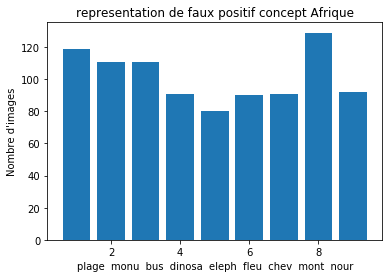

In [70]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [ bad_afr_plage, bad_afr_monument, bad_afr_bus,bad_afr_dinosaure,bad_afr_elepht,bad_afr_fleur,bad_afr_cheval,bad_afr_montagne,bad_afr_nouriture,]
plt.bar(x,y)

plt.xlabel('plage  monu  bus  dinosa  eleph  fleu  chev  mont  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Afrique')
plt.show()

###### Cas de faux positif pour concept Plage

In [71]:
bad_pla_afrique=105
bad_pla_monument=91
bad_pla_bus=118
bad_pla_dinosaure=99
bad_pla_elepht=101
bad_pla_fleur=132
bad_pla_cheval=76
bad_pla_montagne=88
bad_pla_nouriture=101

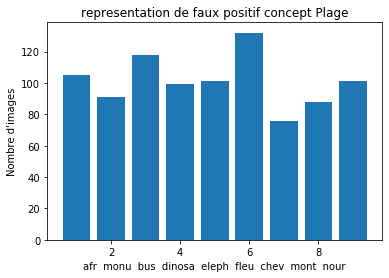

In [72]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [ bad_pla_afrique,bad_pla_monument,bad_pla_bus,bad_pla_dinosaure,bad_pla_elepht,bad_pla_fleur,bad_pla_cheval,bad_pla_montagne,bad_pla_nouriture,]
plt.bar(x,y)

plt.xlabel('afr  monu  bus  dinosa  eleph  fleu  chev  mont  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Plage')
plt.show()

###### Cas de faux positif pour concept Monument

In [73]:
bad_monu_afrique=101
bad_monu_plage=81
bad_monu_bus=106
bad_monu_dinosaure=100
bad_monu_elepht=91
bad_monu_fleur=134
bad_monu_cheval=88
bad_monu_montagne=78
bad_monu_nouriture=111

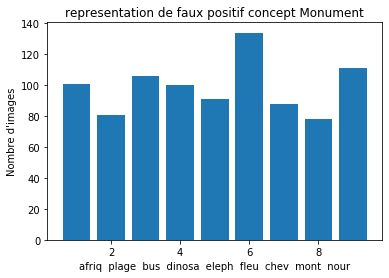

In [74]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [ bad_monu_afrique,
bad_monu_plage,
bad_monu_bus,
bad_monu_dinosaure,
bad_monu_elepht,
bad_monu_fleur,
bad_monu_cheval,
bad_monu_montagne,
bad_monu_nouriture]

plt.bar(x,y)

plt.xlabel('afriq  plage  bus  dinosa  eleph  fleu  chev  mont  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Monument')
plt.show()

###### Cas de faux positif pour concept Bus

In [75]:
bad_bus_afrique=97
bad_bus_plage=123
bad_bus_monument=171
bad_bus_dinosaure=92
bad_bus_elepht=101
bad_bus_fleur=92
bad_bus_cheval=60
bad_bus_montagne=114
bad_bus_nouriture=85 

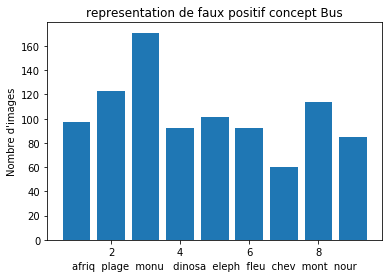

In [76]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [ bad_bus_afrique,
bad_bus_plage,
bad_bus_monument,
bad_bus_dinosaure,
bad_bus_elepht,
bad_bus_fleur,
bad_bus_cheval,
bad_bus_montagne,
bad_bus_nouriture]
plt.bar(x,y)

plt.xlabel('afriq  plage  monu   dinosa  eleph  fleu  chev  mont  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Bus')
plt.show()

###### Cas de faux positif pour concept Dinosaure

In [77]:
bad_din_afrique=74
bad_din_plage=129
bad_din_monument=70
bad_din_bus=119
bad_din_elepht=81
bad_din_fleur=157
bad_din_cheval=153
bad_din_montagne=91
bad_din_nouriture=57

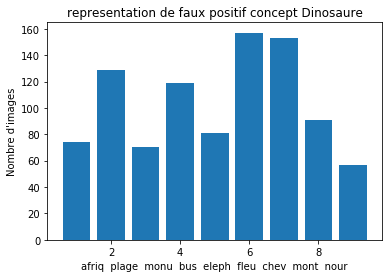

In [78]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [bad_din_afrique,
bad_din_plage,
bad_din_monument,
bad_din_bus,
bad_din_elepht,
bad_din_fleur,
bad_din_cheval,
bad_din_montagne,
bad_din_nouriture]
plt.bar(x,y)

plt.xlabel('afriq  plage  monu  bus  eleph  fleu  chev  mont  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Dinosaure')
plt.show()

###### Cas de faux positif pour concept Elephant

In [79]:
bad_ele_afrique=91
bad_ele_plage=87
bad_ele_monument=96
bad_ele_bus=128
bad_ele_dinosaure=99
bad_ele_fleur=142
bad_ele_cheval=66
bad_ele_montagne=94
bad_ele_nouriture=115

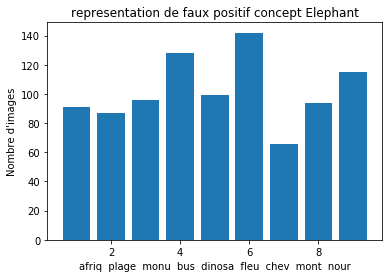

In [80]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [ bad_ele_afrique,
bad_ele_plage,
bad_ele_monument,
bad_ele_bus,
bad_ele_dinosaure,
bad_ele_fleur,
bad_ele_cheval,
bad_ele_montagne,
bad_ele_nouriture]
plt.bar(x,y)

plt.xlabel('afriq  plage  monu  bus  dinosa  fleu  chev  mont  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Elephant')
plt.show()

###### Cas de faux positif pour concept Fleur

In [81]:
bad_fle_afrique=104
bad_fle_plage=119
bad_fle_monument=81
bad_fle_bus=127
bad_fle_dinosaure=123
bad_fle_elepht=68
bad_fle_cheval=99
bad_fle_montagne=97
bad_fle_nouriture=146

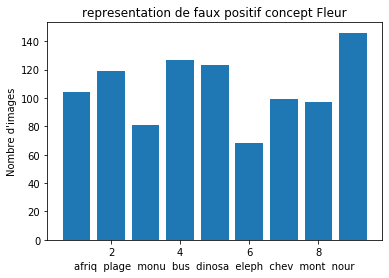

In [82]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [bad_fle_afrique,
bad_fle_plage,
bad_fle_monument,
bad_fle_bus,
bad_fle_dinosaure,
bad_fle_elepht,
bad_fle_cheval,
bad_fle_montagne,
bad_fle_nouriture]
plt.bar(x,y)

plt.xlabel('afriq  plage  monu  bus  dinosa  eleph  chev  mont  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Fleur')
plt.show()

###### Cas de faux positif pour concept Cheval

In [83]:
bad_che_afrique=86
bad_che_plage=119
bad_che_monument=99
bad_che_bus= 121
bad_che_dinosaure=67
bad_che_elepht=111
bad_che_fleur=125
bad_che_montagne=90
bad_che_nouriture=94

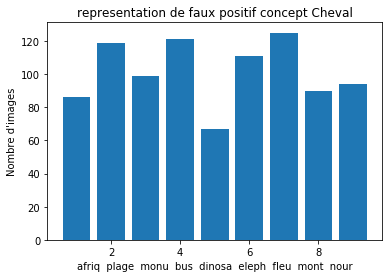

In [84]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [ bad_che_afrique,
bad_che_plage,
bad_che_monument,
bad_che_bus,
bad_che_dinosaure,
bad_che_elepht,
bad_che_fleur,
bad_che_montagne,
bad_che_nouriture]
plt.bar(x,y)

plt.xlabel('afriq  plage  monu  bus  dinosa  eleph  fleu  mont  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Cheval')
plt.show()

###### Cas de faux positif pour concept Montagne

In [85]:
bad_mon_afrique=119
bad_mon_plage=102
bad_mon_monument=87
bad_mon_bus=116
bad_mon_dinosaure=109
bad_mon_elepht= 86
bad_mon_fleur=80
bad_mon_cheval=89
bad_mon_nouriture=105 

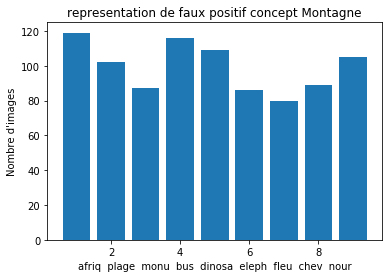

In [86]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [ bad_mon_afrique,
bad_mon_plage,
bad_mon_monument,
bad_mon_bus,
bad_mon_dinosaure,
bad_mon_elepht,
bad_mon_fleur,
bad_mon_cheval,
bad_mon_nouriture ]
plt.bar(x,y)

plt.xlabel('afriq  plage  monu  bus  dinosa  eleph  fleu  chev  nour')
plt.ylabel('Nombre d\'images')
plt.title('representation de faux positif concept Montagne')
plt.show()

###### Cas de faux positif pour concept Nourritures

In [87]:
bad_nou_afrique=122
bad_nou_plage=112
bad_nou_monument=86
bad_nou_bus=124
bad_nou_dinosaure=90
bad_nou_elepht=90
bad_nou_fleur=86
bad_nou_cheval=85
bad_nou_montagne=103

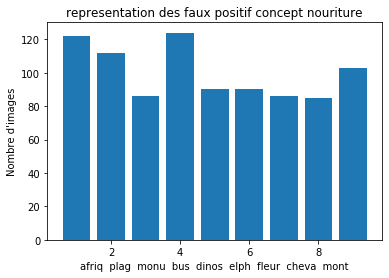

In [68]:

import matplotlib.pyplot as plt
import numpy as np

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [ bad_nou_afrique, bad_nou_plage, bad_nou_monument,bad_nou_bus,bad_nou_dinosaure,bad_nou_elepht,bad_nou_fleur,bad_nou_cheval,bad_nou_montagne]
plt.bar(x,y)

plt.xlabel('afriq  plag  monu  bus  dinos  elph  fleur  cheva  mont')
plt.ylabel('Nombre d\'images')
plt.title('representation des faux positif concept Nourritures')
plt.show()

### CONCLUSION PARTIELLE

### 4-) precision_moyenne(dico_moyenne)

In [88]:
#calcul des précision moyenne pour chaque concept en fonction du résultat totale des recheche

 '''afr,pla,monu,bus,dino,ele,fle,che,mont,nourr=precision_moyenne(dico_moyenne)'''
#dico_precision_moyenne_generale={}  

dico_precision_moyenne_generale

{'Afrique': 8.599999999999996,
 'plage': 8.899999999999993,
 'monument': 10.999999999999986,
 'bus': 6.499999999999999,
 'dinosaure': 6.899999999999998,
 'éléphant': 8.199999999999998,
 'fleur': 3.600000000000001,
 'cheval': 8.799999999999995,
 'montagne': 10.699999999999992,
 'nourriture': 10.199999999999996}

In [93]:
Afrique=dico_precision_moyenne_generale['Afrique']
plage=dico_precision_moyenne_generale['plage']
monument=dico_precision_moyenne_generale['monument']
bus=dico_precision_moyenne_generale['bus']
dinosaure=dico_precision_moyenne_generale['dinosaure']
elepht=dico_precision_moyenne_generale['éléphant']
fleur=dico_precision_moyenne_generale['fleur']
cheval=dico_precision_moyenne_generale['cheval']
montagne=dico_precision_moyenne_generale['montagne']
nourriture=dico_precision_moyenne_generale['nourriture']

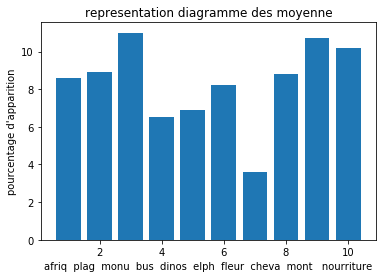

In [94]:
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
y = [ Afrique, plage, monument,bus,dinosaure,elepht,fleur,cheval,montagne,nourriture]
plt.bar(x,y)

plt.xlabel('afriq  plag  monu  bus  dinos  elph  fleur  cheva  mont   nourriture')
plt.ylabel('pourcentage d\'apparition')
plt.title('representation diagramme des moyenne')
plt.show()

# Conclusion